In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings, ydata_profiling, shap

In [19]:
warnings.filterwarnings('ignore')

In [20]:
df= pd.read_csv('./data/cardata.csv', index_col=0)

EDA

In [21]:
summary = df.describe()

In [22]:
summary.drop(['nrOfPictures','postalCode'],axis=1,inplace=True)

In [23]:
summary

,price,yearOfRegistration,powerPS,kilometer,monthOfRegistration
count,3.715280e+05,371528.000000,371528.000000,371528.000000,371528.000000
mean,1.729514e+04,2004.577997,115.549477,125618.688228,5.734445
std,3.587954e+06,92.866598,192.139578,40112.337051,3.712412
min,0.000000e+00,1000.000000,0.000000,5000.000000,0.000000
25%,1.150000e+03,1999.000000,70.000000,125000.000000,3.000000
50%,2.950000e+03,2003.000000,105.000000,150000.000000,6.000000
75%,7.200000e+03,2008.000000,150.000000,150000.000000,9.000000
max,2.147484e+09,9999.000000,20000.000000,150000.000000,12.000000


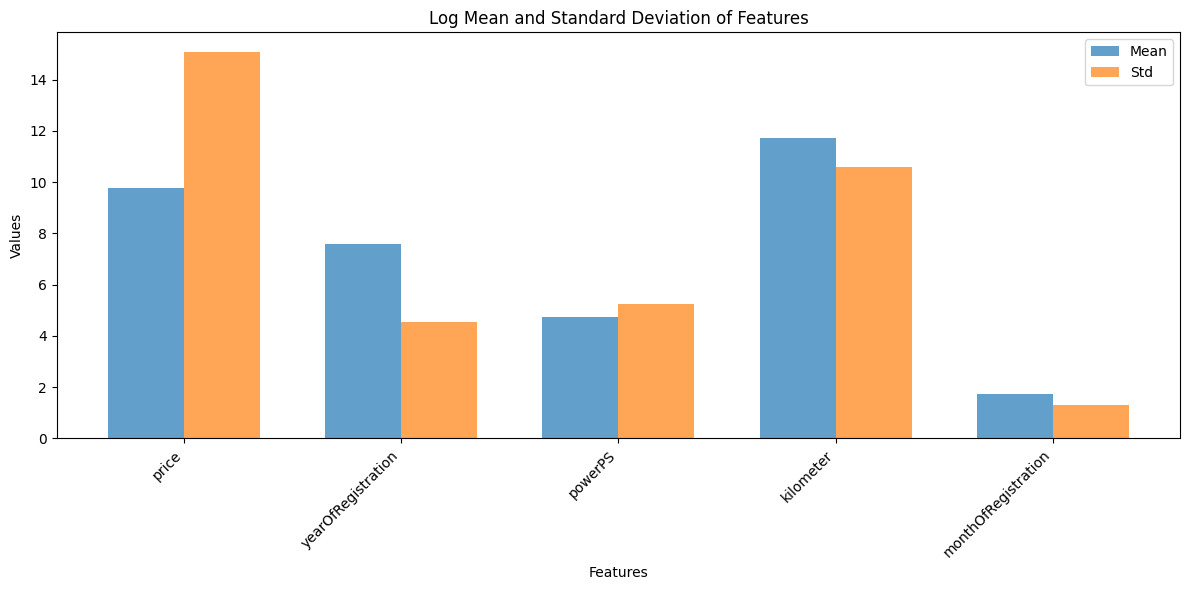

In [24]:
x_labels = list(summary.columns)
y1 = np.log(list(summary.loc['mean']))
y2 = np.log(list(list(summary.loc['std'])))

width = 0.35
x = np.arange(len(x_labels))

plt.figure(figsize=(12,6))

plt.bar(x - width/2, y1, width=width, label='Mean', alpha=0.7)
plt.bar(x + width/2, y2, width=width, label='Std', alpha=0.7)

plt.xticks(x, x_labels, rotation=45, ha='right')
plt.xlabel('Features')
plt.ylabel('Values')
plt.title('Log Mean and Standard Deviation of Features')
plt.legend()

plt.tight_layout()
plt.show()

**Note:**  
- `powerPS`, `yearOfRegistration`, and `monthOfRegistration` exhibit very little variation (low standard deviation). Further investigation will be conducted.


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 371528 entries, 0 to 371527
Data columns (total 20 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   dateCrawled          371528 non-null  object
 1   name                 371528 non-null  object
 2   seller               371528 non-null  object
 3   offerType            371528 non-null  object
 4   price                371528 non-null  int64 
 5   abtest               371528 non-null  object
 6   vehicleType          333659 non-null  object
 7   yearOfRegistration   371528 non-null  int64 
 8   gearbox              351319 non-null  object
 9   powerPS              371528 non-null  int64 
 10  model                351044 non-null  object
 11  kilometer            371528 non-null  int64 
 12  monthOfRegistration  371528 non-null  int64 
 13  fuelType             338142 non-null  object
 14  brand                371528 non-null  object
 15  notRepairedDamage    299468 non-null  o

In [26]:
# Missing Values
dataInfo =[]
for col in df.columns:
  num_nam = df[col].isna().sum()
  dataInfo.append([col,num_nam,num_nam/len(df)*100,df[col].nunique()])

In [27]:
mising_value_df = pd.DataFrame(dataInfo,columns=['Feature','NumNan','PercentNan','NumUnique'])

In [28]:
mising_value_df

,Feature,NumNan,PercentNan,NumUnique
0,dateCrawled,0,0.000000,280500
1,name,0,0.000000,233531
2,seller,0,0.000000,2
3,offerType,0,0.000000,2
4,price,0,0.000000,5597
5,abtest,0,0.000000,2
6,vehicleType,37869,10.192771,8
7,yearOfRegistration,0,0.000000,155
8,gearbox,20209,5.439429,2
9,powerPS,0,0.000000,794


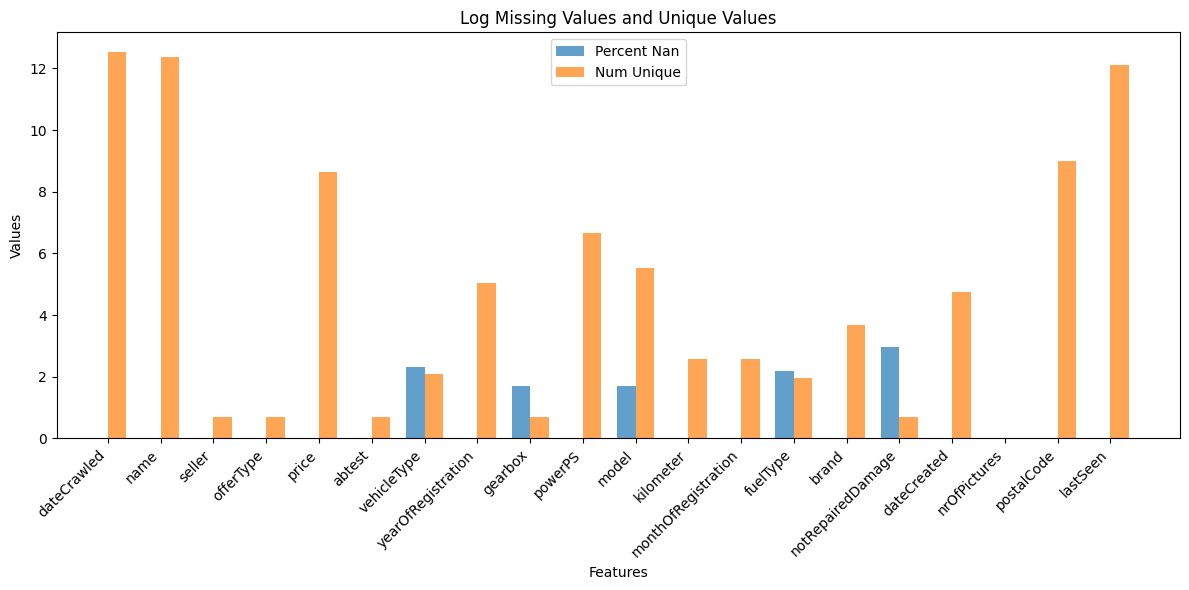

In [29]:
x_labels = list(mising_value_df['Feature'])
y1 = np.log(list(mising_value_df['PercentNan']))
y2 = np.log(list(mising_value_df['NumUnique']))

width = 0.35
x = np.arange(len(x_labels))

plt.figure(figsize=(12,6))

plt.bar(x - width/2, y1, width=width, label='Percent Nan', alpha=0.7)
plt.bar(x + width/2, y2, width=width, label='Num Unique', alpha=0.7)

plt.xticks(x, x_labels, rotation=45, ha='right')
plt.xlabel('Features')
plt.ylabel('Values')
plt.title('Log Missing Values and Unique Values')
plt.legend()

plt.tight_layout()
plt.show()

**Note:**

- `nrOfPictures` has only one unique value and will be removed.
- `vehicleType` and `notRepairedDamage` have the highest number of missing values; these will require further investigation.


In [30]:
df.drop('nrOfPictures', axis=1, inplace=True)

In [31]:
# 4. German to English, as best as I can
df['gearbox'] = df['gearbox'].apply(lambda g: 'Manual' if g == 'manuell' else 'Automatic')
df['notRepairedDamage'] = df['notRepairedDamage'].apply(lambda g: 'Yes' if g == 'ja' else 'No' if g =='nein' else 'NaN')
df.loc[df['fuelType'] == 'benzin', 'fuelType'] = 'Petrol'
df.loc[df['fuelType'] == 'andere', 'fuelType'] = 'Other'

In [32]:
categorical_cols = ['seller','abtest','vehicleType','gearbox','fuelType','notRepairedDamage','offerType']
data = []
for col in categorical_cols:
  data.append(df[col].value_counts())

**Note:**

- `brand`, `model`, and `powerPS` have a large number of unique values; therefore, representing them with pie charts is not meaningful.


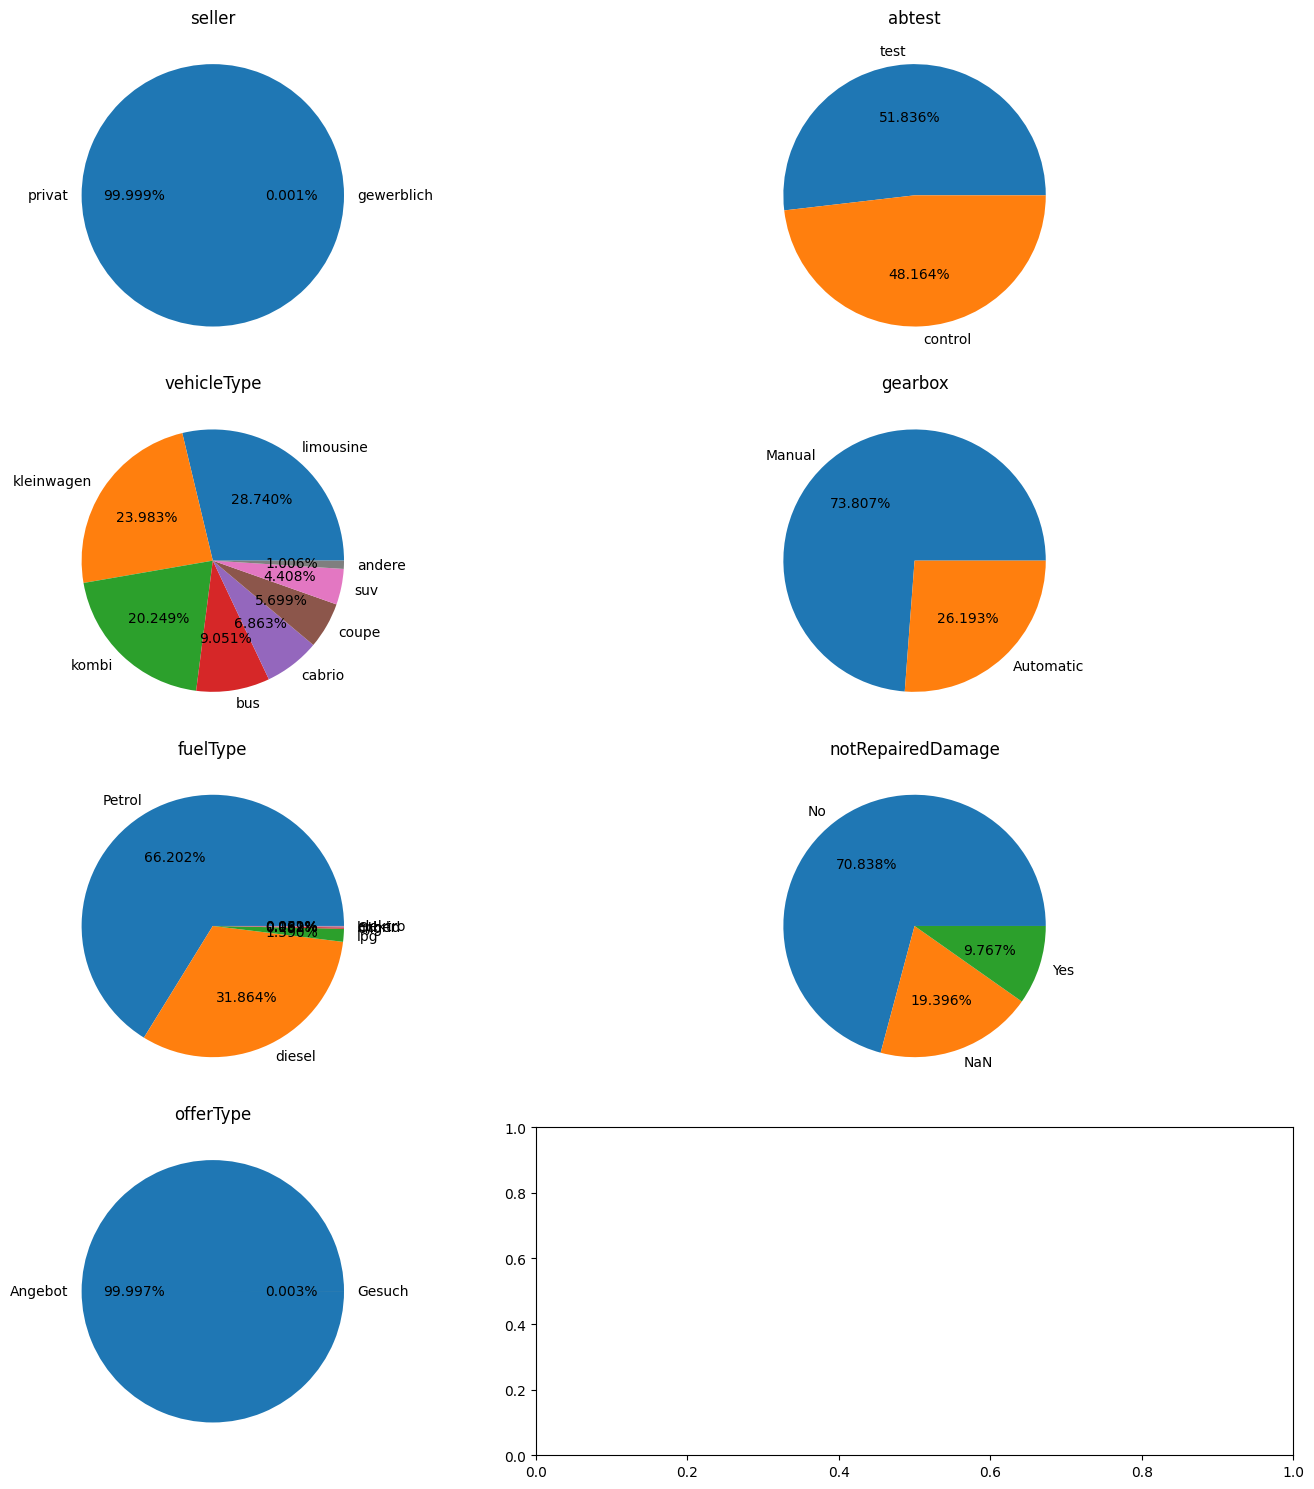

In [33]:
fig,ax = plt.subplots(4,2,figsize=(15,15))
axes = ax.flatten()
for i,col_data in enumerate(data):
  axes[i].pie(col_data,labels=col_data.index,autopct='%1.3f%%')
  axes[i].set_title(categorical_cols[i])
plt.tight_layout()
plt.show()

**Note:**

- `seller` and `offerType` each have only 2 unique values, with one value appearing in less than 0.003% of rows. These columns will be removed.
- Rows with rare `fuelType` values (`lpg`, `cng`, `hybrid`, `other`, and `elektro`) contribute very little to the dataset and will be dropped.
- `notRepairedDamage` contains 19.3% missing values; rows with missing entries in this column will be removed.


In [ ]:
# Drop the 'seller', 'offerType' columns
df.drop('seller', axis=1, inplace=True)
df.drop('offerType', axis=1, inplace=True)


# Drop rows with feul type lpg, cng etc
df = df[(df['fuelType'] == 'Petrol') | (df['fuelType'] == 'Diesel')]

df.head()

,dateCrawled,name,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,dateCreated,postalCode,lastSeen
index,,,,,,,,,,,,,,,,,
0,2016-03-24 11:52:17,Golf_3_1.6,480,test,NaN,1993,Manual,0,golf,150000,0,Petrol,volkswagen,NaN,2016-03-24 00:00:00,70435,2016-04-07 03:16:57
3,2016-03-17 16:54:04,GOLF_4_1_4__3TÜRER,1500,test,kleinwagen,2001,Manual,75,golf,150000,6,Petrol,volkswagen,No,2016-03-17 00:00:00,91074,2016-03-17 17:40:17
5,2016-04-04 17:36:23,BMW_316i___e36_Limousine___Bastlerfahrzeug__Ex...,650,test,limousine,1995,Manual,102,3er,150000,10,Petrol,bmw,Yes,2016-04-04 00:00:00,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,Peugeot_206_CC_110_Platinum,2200,test,cabrio,2004,Manual,109,2_reihe,150000,8,Petrol,peugeot,No,2016-04-01 00:00:00,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,VW_Derby_Bj_80__Scheunenfund,0,test,limousine,1980,Manual,50,andere,40000,7,Petrol,volkswagen,No,2016-03-21 00:00:00,19348,2016-03-25 16:47:58


**Note:**

- `lastSeen` and `dateCrawled` will be removed as they have no impact on the target variable (`price`).
- Rows with `yearOfRegistration` below 1980 or above 2025 will be dropped, as values outside this range are likely erroneous.


In [ ]:
#  DateTime Conversion --> Drop 'dateCrawled' and 'lastSeen'
df.drop(['lastSeen', 'dateCrawled'], axis=1, inplace=True)
df['dateCreated'] = pd.to_datetime(df['dateCreated'])
#  Define a range for the 'yearOfRegistration'
df = df[df['yearOfRegistration'].between(1980, 2025)]

In [36]:
df.head()

,name,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,dateCreated,postalCode
index,,,,,,,,,,,,,,,
0,Golf_3_1.6,480,test,NaN,1993,Manual,0,golf,150000,0,Petrol,volkswagen,NaN,2016-03-24,70435
3,GOLF_4_1_4__3TÜRER,1500,test,kleinwagen,2001,Manual,75,golf,150000,6,Petrol,volkswagen,No,2016-03-17,91074
5,BMW_316i___e36_Limousine___Bastlerfahrzeug__Ex...,650,test,limousine,1995,Manual,102,3er,150000,10,Petrol,bmw,Yes,2016-04-04,33775
6,Peugeot_206_CC_110_Platinum,2200,test,cabrio,2004,Manual,109,2_reihe,150000,8,Petrol,peugeot,No,2016-04-01,67112
7,VW_Derby_Bj_80__Scheunenfund,0,test,limousine,1980,Manual,50,andere,40000,7,Petrol,volkswagen,No,2016-03-21,19348


### Count Analysis of `brand`

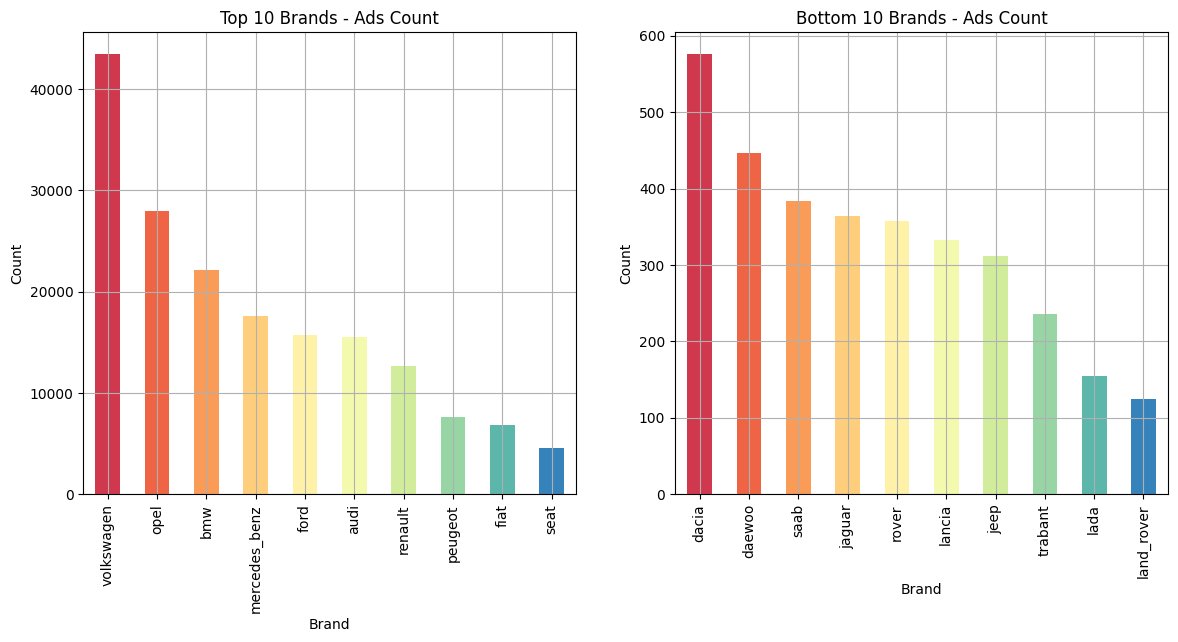

In [37]:
colors_10_1 = sns.color_palette("Spectral", 10)
colors_10_2 = sns.color_palette("Set3", 10)
colors_5 = sns.color_palette('Accent', 5)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

df['brand'].value_counts().head(10).plot(kind='bar', title='Top 10 Brands - Ads Count', color=colors_10_1, ax=axes[0], xlabel='Brand', ylabel='Count', grid=True)
df['brand'].value_counts().tail(10).plot(kind='bar', title='Bottom 10 Brands - Ads Count', color=colors_10_1, ax=axes[1], xlabel='Brand', ylabel='Count', grid=True)
plt.show()

**Note:**

- There is a high degree of variance in the `brand` feature, indicating that the data is diverse and potentially valuable for analysis.


### Count analysis of models

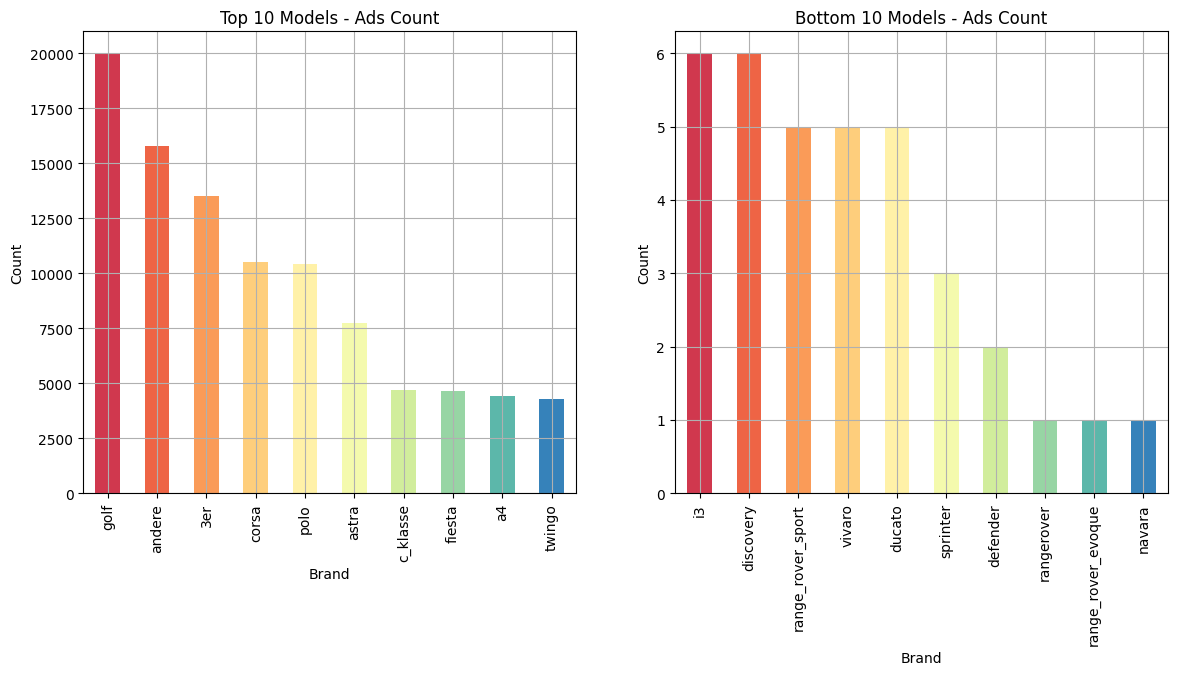

In [38]:
colors_10_1 = sns.color_palette("Spectral", 10)
colors_10_2 = sns.color_palette("Set3", 10)
colors_5 = sns.color_palette('Accent', 5)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

df['model'].value_counts().head(10).plot(kind='bar', title='Top 10 Models - Ads Count', color=colors_10_1, ax=axes[0], xlabel='Brand', ylabel='Count', grid=True)
df['model'].value_counts().tail(10).plot(kind='bar', title='Bottom 10 Models - Ads Count', color=colors_10_1, ax=axes[1], xlabel='Brand', ylabel='Count', grid=True)
plt.show()

**Note** 
- Clearly lots of varaince. so data is useful

### Count analysis of Vechile type

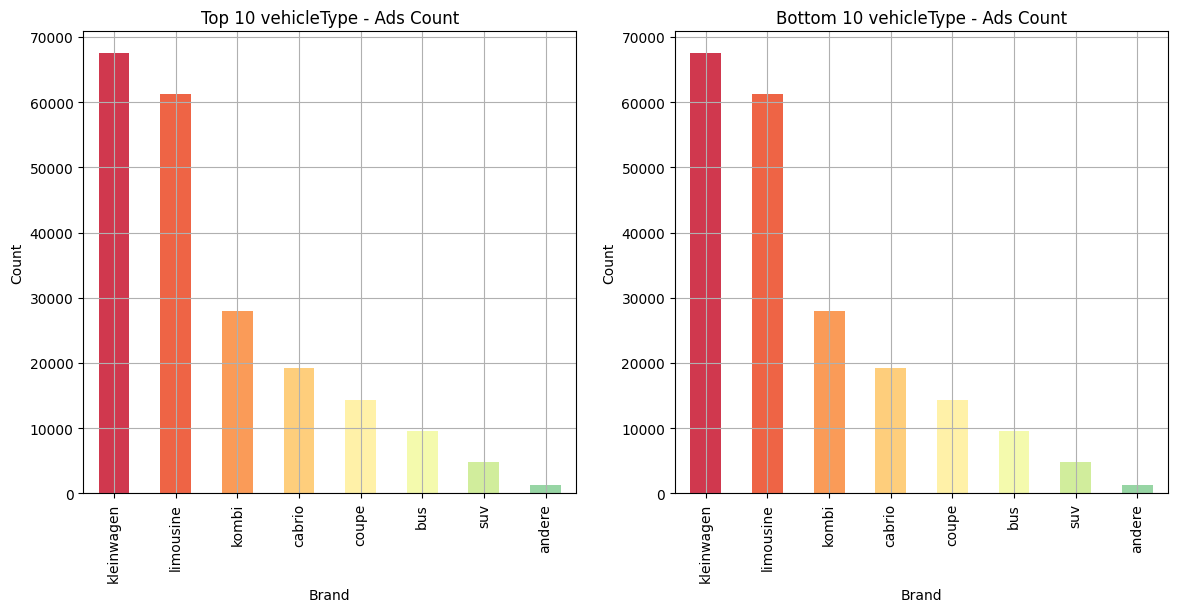

In [39]:
colors_10_1 = sns.color_palette("Spectral", 10)
colors_10_2 = sns.color_palette("Set3", 10)
colors_5 = sns.color_palette('Accent', 5)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

df['vehicleType'].value_counts().head(10).plot(kind='bar', title='Top 10 vehicleType - Ads Count', color=colors_10_1, ax=axes[0], xlabel='Brand', ylabel='Count', grid=True)
df['vehicleType'].value_counts().tail(10).plot(kind='bar', title='Bottom 10 vehicleType - Ads Count', color=colors_10_1, ax=axes[1], xlabel='Brand', ylabel='Count', grid=True)
plt.show()

**Note** 
- Clearly lots of varaince. so data is useful